In [155]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys, os, subprocess, glob, shutil
import cartopy
import cartopy.crs as ccrs
from datetime import datetime, timedelta
import xarray as xr
import pandas as pd
from scipy import stats

## Useful functions

In [156]:
### It can be useful to estimate the area of each grid cell as well as the distance between two of them. Let's assume Earth is a sphere and grid cells are rectangulars.
def distance_on_unit_sphere(lat1, long1, lat2, long2):
    # Convert latitude and longitude to spherical coordinates in radians
    degrees_to_radians = np.pi / 180.0
    phi1 = (90.0 - lat1) * degrees_to_radians
    phi2 = (90.0 - lat2) * degrees_to_radians
    theta1 = long1 * degrees_to_radians
    theta2 = long2 * degrees_to_radians
    # Compute spherical distance
    cos = (np.sin(phi1) * np.sin(phi2) * np.cos(theta1 - theta2) +
           np.cos(phi1) * np.cos(phi2))
    arc = np.arccos(np.clip(cos, -1.0, 1.0))  # Clip to avoid numerical issues

    return arc

def compute_area(lons_nxsim, lats_nxsim):
    nx = lons_nxsim.shape[1]
    ny = lons_nxsim.shape[0]
    dx = np.zeros_like(lons_nxsim)
    dy = np.zeros_like(lons_nxsim)

    R = 6370997  # Earth radius in meters

    # Compute dx (north-south distances)
    dx[:-1, :] = distance_on_unit_sphere(
        lats_nxsim[:-1, :], lons_nxsim[:-1, :],
        lats_nxsim[1:, :], lons_nxsim[1:, :]
    ) * R

    # Compute dy (east-west distances)
    dy[:, :-1] = distance_on_unit_sphere(
        lats_nxsim[:, :-1], lons_nxsim[:, :-1],
        lats_nxsim[:, 1:], lons_nxsim[:, 1:]
    ) * R

    # Fill last row and column
    dx[-1, :] = dx[-2, :]
    dy[:, -1] = dy[:, -2]

    # Compute area
    area = dx * dy
    return area



## NeXtSIM-WAVEWATCH III

COPILOT says: The neXtSIM-WAVEWATCH III framework is a coupled modeling system that integrates the sea ice model neXtSIM with the wave model WAVEWATCH III. This system is designed to simulate and forecast interactions between ocean waves and sea ice, particularly in the Arctic's Marginal Ice Zone (MIZ). neXtSIM uses a Maxwell elasto-brittle rheology to track sea ice damage, while WAVEWATCH III models wave dynamics. Together, they help understand how waves fragment sea ice and influence its movement and melting 1 2. This is crucial for predicting changes in the Arctic environment due to climate change.

******
_References_:

Boutin, G., Williams, T., Horvat, C., & Brodeau, L. (2022). Modelling the Arctic wave-affected marginal ice zone: A comparison with ICESat-2 observations. Philosophical Transactions of the Royal Society A: Mathematical, Physical and Engineering Sciences, 380(2235), 20210262. https://doi.org/10.1098/rsta.2021.0262

Boutin, G., Williams, T., Rampal, P., Olason, E., & Lique, C. (2021). Wave–sea-ice interactions in a brittle rheological framework. The Cryosphere, 15(1), 431–457. https://doi.org/10.5194/tc-15-431-2021


![title](Supporting_material_WW3-neXtSIM/WW3-neXtSIM_schematic.png)

## Path to model outputs

In [157]:
path_nextsim_outputs = "/home/nextsim-workshop/data-nextsim-workshop2025/ww3-nextsim/analysis/nextsim_outputs"
path_ww3_outputs     = "/home/nextsim-workshop/data-nextsim-workshop2025/ww3-nextsim/analysis/ww3_outputs"

nextsim_file_format  = f"{path_nextsim_outputs}/%Y/Moorings_%Ym%m.nc" ## One file per month contains all variables
ww3_file_format      = f"{path_ww3_outputs}/%Y/ww3.%Y%m_*.nc" ### One file per variable AND per month 
##(This could be changed, but I started like this in my PhD and I am used to it in my workflow, sorry)


## Reading into neXtSIM outputs

In [199]:
### Pick your favourite year/month (among what is available)
date = datetime(2021,3,1) 

### The name of the corresponding file
nextsim_file = date.strftime(nextsim_file_format)
print(f"\nWe are looking for {nextsim_file}.\n\n\n")

### We could check whether it exists first, but the error in open_dataset would tell us if this is not the case anyway.
ds_nxm = xr.open_dataset(nextsim_file)
print(ds_nxm)

grid_area=compute_area(ds_nxm["longitude"],ds_nxm["latitude"]) / 1e6 #converting to km2
# Ensure grid_area is an xarray DataArray with matching dimensions
grid_area_da = xr.DataArray(grid_area, coords={"y": ds_nxm.y, "x": ds_nxm.x}, dims=("y", "x"))



We are looking for /home/nextsim-workshop/data-nextsim-workshop2025/ww3-nextsim/analysis/nextsim_outputs/2021/Moorings_2021m03.nc.



<xarray.Dataset>
Dimensions:     (time: 248, y: 448, x: 304, nv: 2)
Coordinates:
    latitude    (y, x) float32 ...
    longitude   (y, x) float32 ...
  * time        (time) datetime64[ns] 2021-03-01 ... 2021-03-31T21:00:00
Dimensions without coordinates: y, x, nv
Data variables: (12/16)
    dmax        (time, y, x) float32 ...
    dmean       (time, y, x) float32 ...
    dvi_thermo  (time, y, x) float32 ...
    sic         (time, y, x) float32 ...
    sic_young   (time, y, x) float32 ...
    sit         (time, y, x) float32 ...
    ...          ...
    sss         (time, y, x) float32 ...
    sst         (time, y, x) float32 ...
    t2m         (time, y, x) float32 ...
    taux        (time, y, x) float32 ...
    tauy        (time, y, x) float32 ...
    time_bnds   (time, nv) datetime64[ns] ...
Attributes:
    Conventions:  CF-1.6
    institution:  NER

# What can we do with neXtSIM?

### A quick example: Computing a "lead fraction"

The lead fraction is the fraction occupied by sea ice leads. It depends on the definition, but we can consider leads as openings in the sea ice. Openings mean that leads are either open water, or very thin, uncosolidated sea ice. The open water fraction can be computed as 1-sic, "sic" being the total sea ice concentration. 

Additionally, the lead fraction can be defined as $1-(\rm sic-sic_{young})$. But what is $\rm sic_{young}$?

neXtSIM includes two sea ice categories, the "young" ice and the "consolidated" ice. "Young" ice is ice that grows in open water until it reaches a thickness threshold (generally around 20/30cm). This threshold is a model parameter. Consolidated ice is, well, all the rest. "Young" ice is generally found in marginal ice zones, leads and polynyas. Therefore, "sic_young" is the fraction occupied by young ice. The fraction occupied by consolidated ice can be derived as $\rm (sic-sic_{young})$. If we consider that leads are not just open water, but also include young ice that has not yet been consolidated, the lead fraction should be equal to $1- \rm sic_{consolidated}=1-(sic-sic_{young})$.  

This definition works well in a domain away from shelves and MIZs, in winter, as it will definitely highlight leads. But close to the ice edge, it will also include the MIZ, and does not differentiate between leads and polynyas. 

In [200]:
ds_nxm['sic_consolidated'] = ds_nxm["sic"]-ds_nxm["sic_young"]
## Computing the lead fraction
ds_nxm['lead_frac'] = 1-ds_nxm['sic_consolidated']
ds_nxm['lead_frac'] = ds_nxm['lead_frac'].where(ds_nxm['sic_consolidated']>=.15,np.nan)

### The conservative version, we ignore young ice, leads are only open water.
#ds_nxm['lead_frac_conservative'] = 1-ds_nxm["sic"]
#ds_nxm['lead_frac_conservative'] = ds_nxm['lead_frac_conservative'].where(ds_nxm["sic"]>=.15,np.nan)


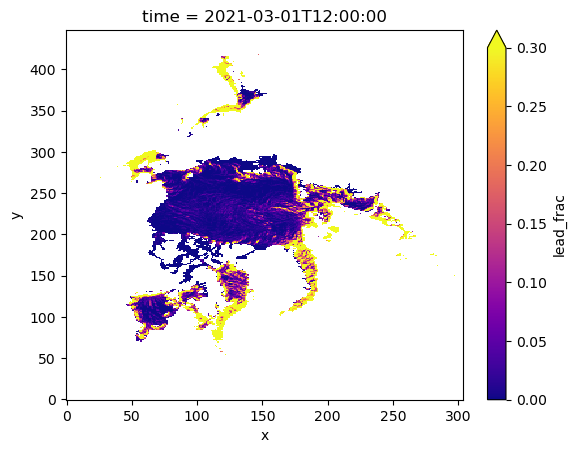

In [201]:
## Example plot
ds_nxm['lead_frac'].isel(time=4).plot(cmap="plasma",vmin=0,vmax=0.3)

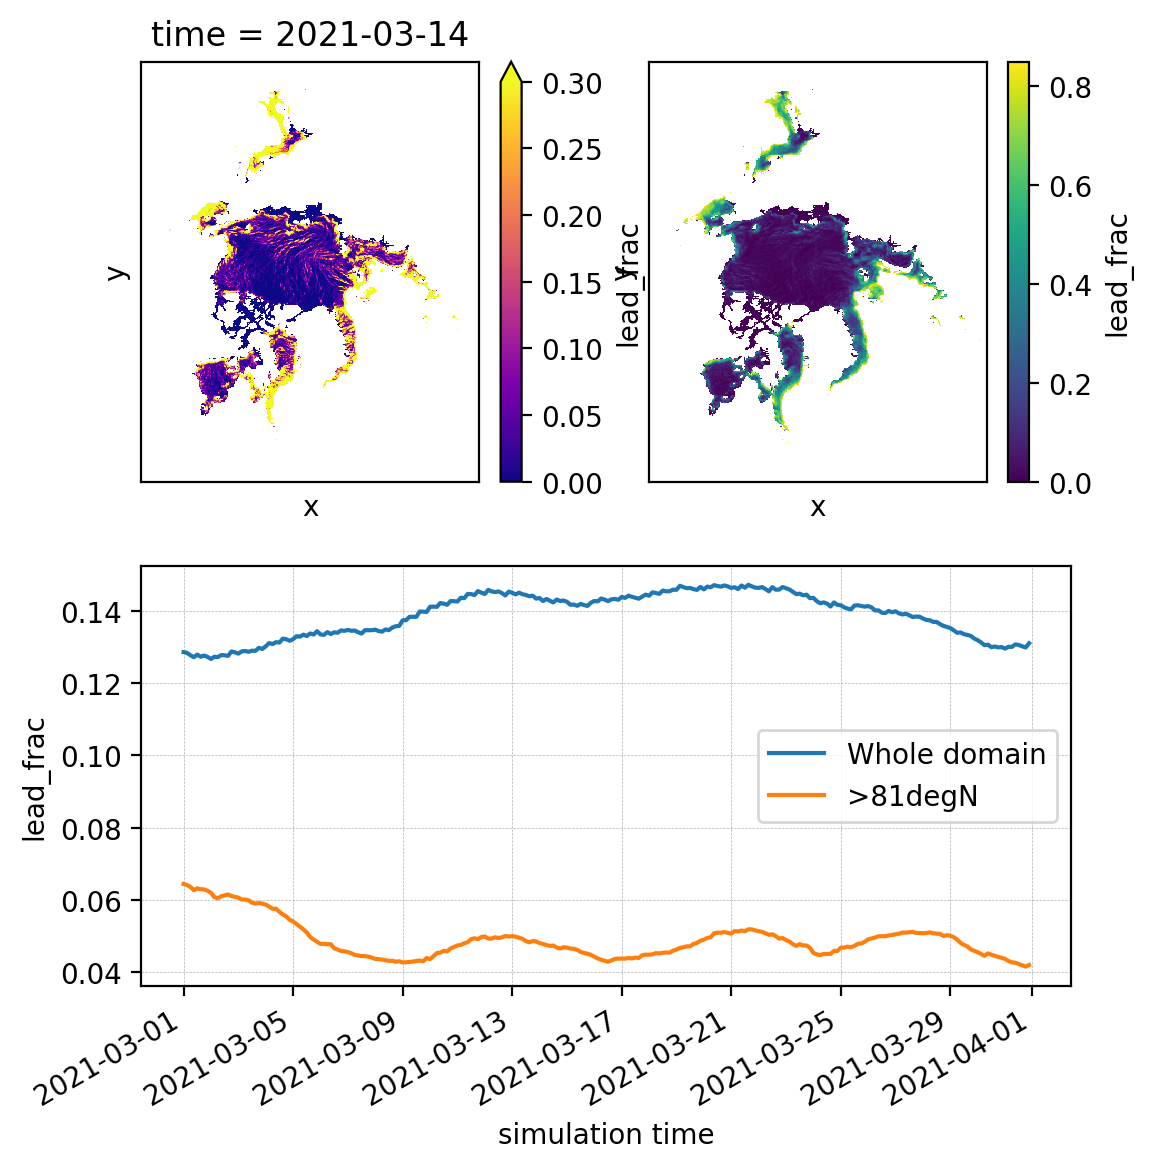

In [202]:
### Making a fancier figure

def format_map():
    plt.xticks([])
    plt.yticks([])

def format_timeseries():
    plt.grid(ls="--",lw=0.25)
    plt.legend()

fig=plt.figure(figsize=(6,6),dpi=200)

ax=fig.add_subplot(221)
## Select a snapshot with a date
ds_nxm['lead_frac'].sel(time='2021-03-14T00:00:00').plot(cmap="plasma",vmin=0,vmax=0.3)
format_map()
## Plot the monthly mean
ax=fig.add_subplot(222)
ds_nxm['lead_frac'].mean(dim=("time")).plot()
format_map()

### Investigate the temporal evolution of the mean lead fraction
ax=fig.add_subplot(212)
ds_nxm['lead_frac'].mean(dim=("x","y"),skipna=None).plot(label="Whole domain")
ds_nxm['lead_frac'].where(ds_nxm['latitude']>81).mean(dim=("x","y"),skipna=None).plot(label=">81degN")

#### Technically we should use a weighted average for area differences between grid cells.

format_timeseries()

### Define a concentration MIZ.


The marginal ice zone definition is somewhat of a blurry thing. Qualitatively, it generally carries the idea of a region that is ice-covered (partially or totally), but where processes associated with atmosphere--ocean interactions in open ocean are still occurring. It is distinct from pack ice, where the ocean surface

Now, in practice, how do quantitaively define the MIZ? A standard criterion uses the sea ice concentration This is not so different from the lead fraction.

Text(0, 0.5, 'MIZ extent [km$^2$]')

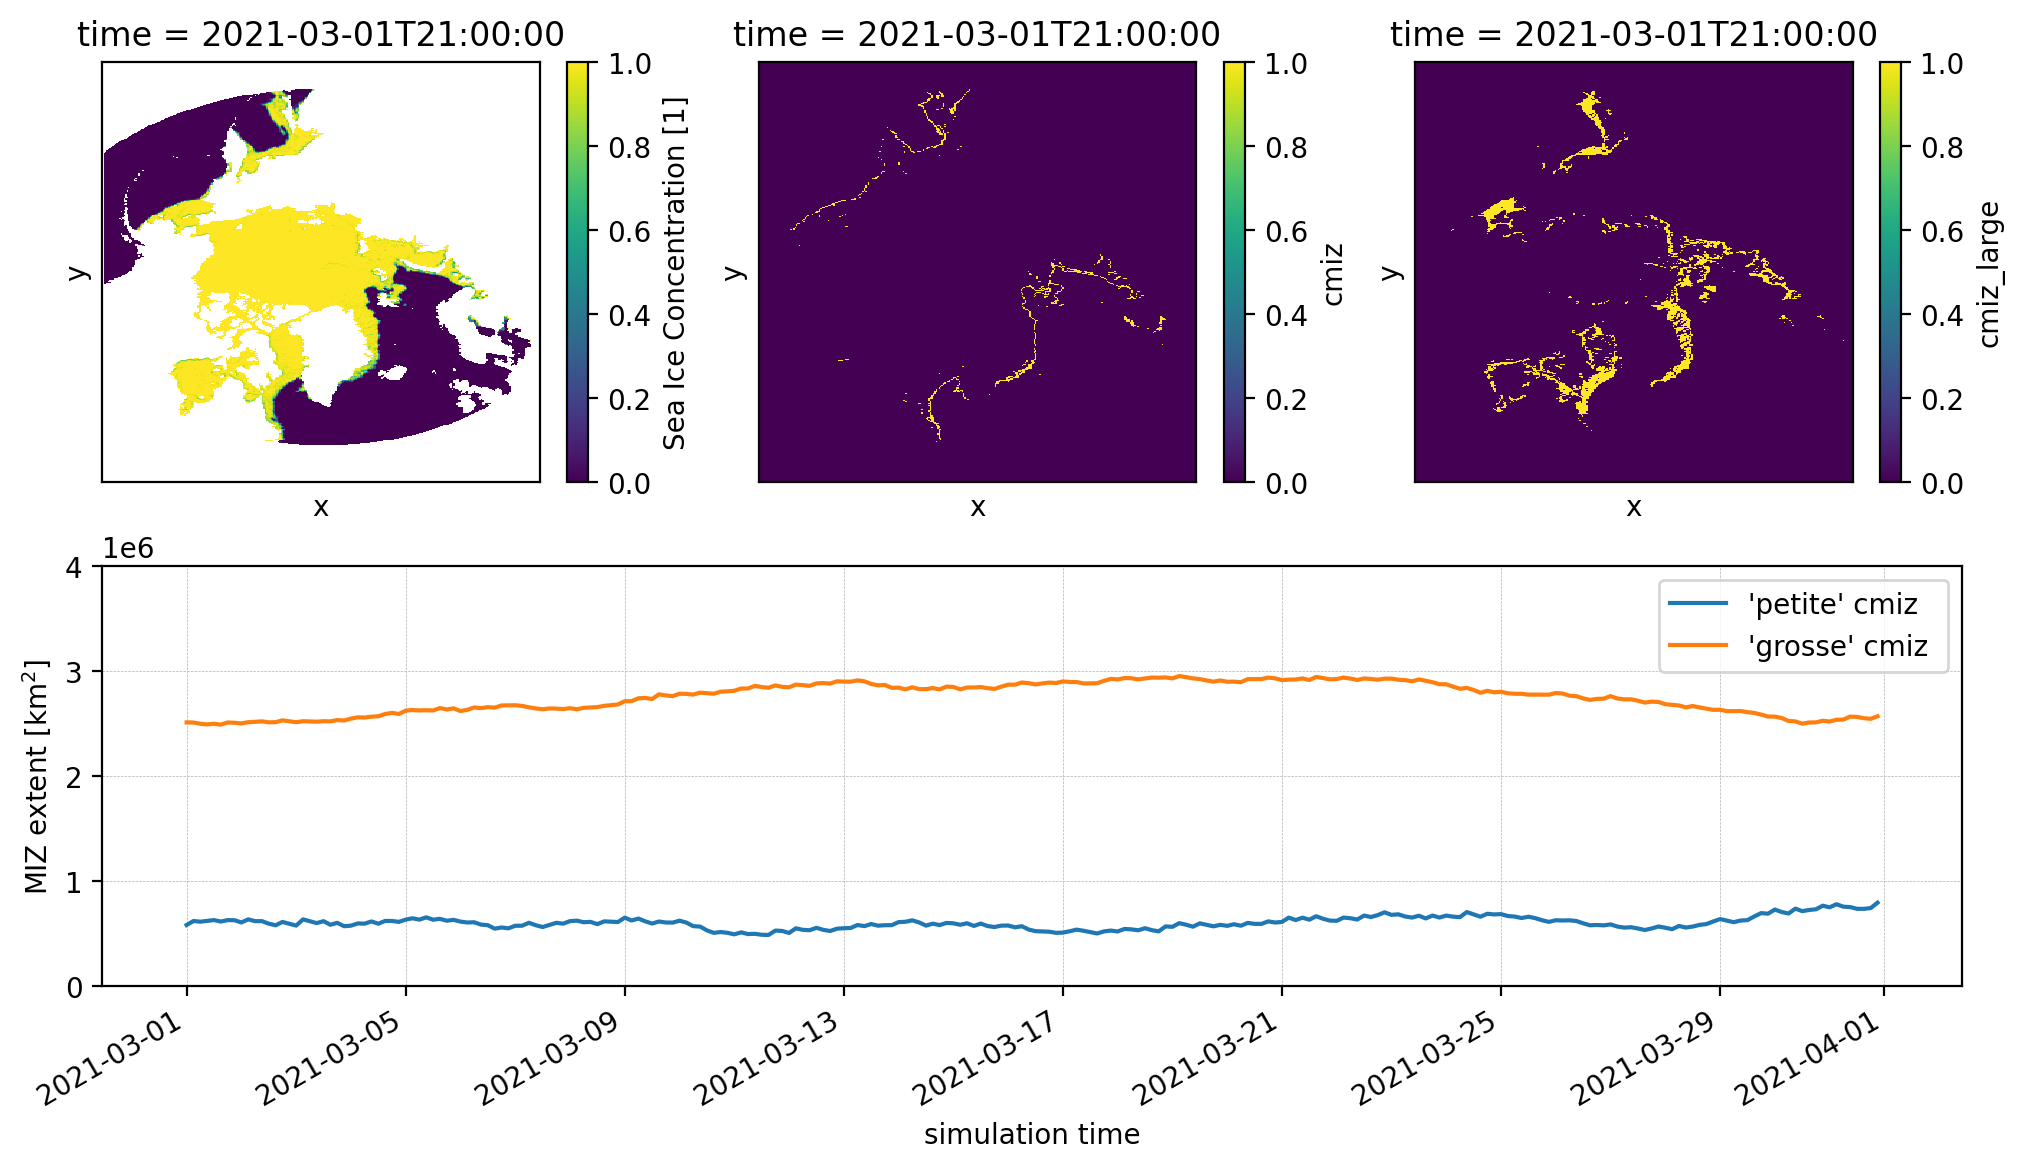

In [203]:
#####
ds_nxm["cmiz"]=xr.where( (ds_nxm['sic']<.8) & (ds_nxm['sic']>=.15),1,0)
ds_nxm["cmiz_large"]=xr.where( (ds_nxm['sic_consolidated']<.8) & (ds_nxm['sic_consolidated']>=.15),1,0)

tt = 7 #time index
fig=plt.figure(figsize=(12,6),dpi=200)

ax=fig.add_subplot(231)
ds_nxm["sic"].isel(time=tt).plot()
format_map()

ax=fig.add_subplot(232)
ds_nxm["cmiz"].isel(time=tt).plot()
format_map()

ax=fig.add_subplot(233)
ds_nxm["cmiz_large"].isel(time=tt).plot()
format_map()


###
ax=fig.add_subplot(212)

# Area-weighted sum of cmiz-es
cmiz_area_sum = (ds_nxm["cmiz"] * grid_area_da).sum(dim=("x", "y"))
cmiz_area_sum.plot(ax=ax, label="'petite' cmiz ")

cmiz_large_area_sum = (ds_nxm["cmiz_large"] * grid_area_da).sum(dim=("x", "y"))
cmiz_large_area_sum.plot(ax=ax, label="'grosse' cmiz ")

format_timeseries()
plt.ylim([0,4e6])
plt.ylabel(r"MIZ extent [km$^2$]")

The concentration criterion is a bit arbitrary... If we consider the total concentration, then the MIZ is limited to the very outer end of the ice edge. If you distinguish young ice (that is thin and has no internal stress) from consolidated ice, leads and polynyas are also included. Basically, the 0.15-->0.8 concentration criterion works pretty well to define the MIZ only when leads and polynyas are not resolved. Or maybe they should be considered MIZ?


### Define a floe size MIZ


Ok, so we have talked about the cMIZ, but we have a **coupled** wave--sea-ice system... Waves can break the sea ice. In the neXtSIM outputs, we can find some information about floe-size parameters. These are: 
- the mean floe size, characteristic of the average size of floes that occupy a significant fraction of the cell area
- the maximum floe size, characteristic of the biggest floes in the grid cell

For details, see:
Boutin, G., Williams, T., Rampal, P., Olason, E., & Lique, C. (2021). Wave–sea-ice interactions in a brittle rheological framework. The Cryosphere, 15(1), 431–457. https://doi.org/10.5194/tc-15-431-2021




### Which floe size should we use as a threshold?

Let's try a few different ones

In [205]:
ds_nxm["dmiz_100"]= xr.where( (ds_nxm['dmax']<=100) & (ds_nxm['sic']>=.15), 1, 0)
ds_nxm["dmiz_500"]= xr.where( (ds_nxm['dmax']<=500) & (ds_nxm['sic']>=.15), 1, 0)
ds_nxm["dmiz_50"] = xr.where( (ds_nxm['dmax']<=50) & (ds_nxm['sic']>=.15), 1, 0)

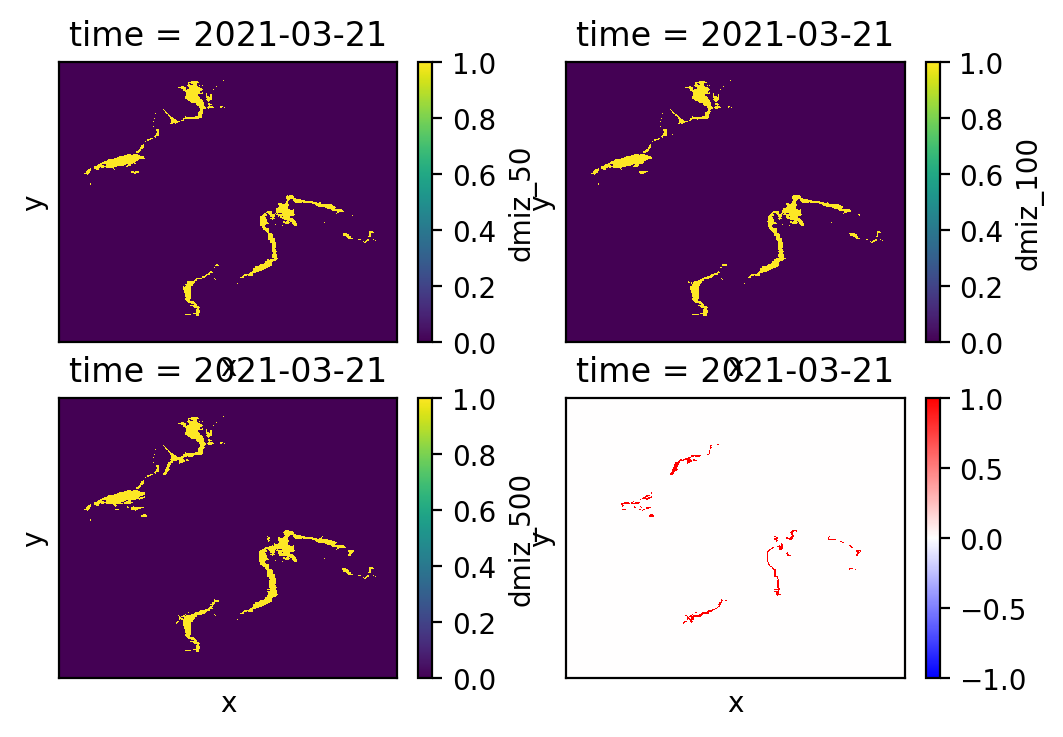

In [211]:
sel_time='2021-03-21T00:00:00'

fig=plt.figure(figsize=(6,4),dpi=200)

ax=fig.add_subplot(221)
ds_nxm["dmiz_50"].sel(time=sel_time).plot()
format_map()

ax=fig.add_subplot(222)
ds_nxm["dmiz_100"].sel(time=sel_time).plot()
format_map()

ax=fig.add_subplot(223)
ds_nxm["dmiz_500"].sel(time=sel_time).plot()
format_map()

ax=fig.add_subplot(224)
(ds_nxm["dmiz_500"]-ds_nxm["dmiz_50"]).sel(time=sel_time).plot(cmap="bwr",vmin=-1,vmax=1)
format_map()

# WAVEWATCH III outputs

Unsurprisingly, they contain information about waves, like significant wave height (hs), peak frequency/period (fp)... but also information about sea ice like concentration and thickness, as well as some "floe size" information.

In [228]:
date=datetime(2021,1,1)

### Simple openings
if 0 :
    ## Select all variables for 1 month
    ww3_file_format      = f"{path_ww3_outputs}/%Y/ww3.%Y%m_*.nc" ### One file per variable AND per month 
    ## Select 1 variable (hs) for all months
    ww3_file_format      = f"{path_ww3_outputs}/%Y/ww3.%Y??_hs.nc" ### One file per variable AND per month 

    ww3_files = glob.glob(date.strftime(ww3_file_format)) ### You could just feed date.strftime(ww3_file_format) to xr.open_mfdataset()

var_selection=["hs","ice","ic3","ic1","fp"]

#var_selection=["hs","ice"]

date_s = datetime(2021,1,1)
date_e = datetime(2021,5,1)

ww3_files = generate_ww3_file_list(path_ww3_outputs, var_selection, date_s, date_e)
ds_ww3= xr.open_mfdataset(ww3_files, drop_variables=["longitude","latitude"])
print(ds_ww3)

2021-01-01 00:00:00
2021-02-01 00:00:00
2021-03-01 00:00:00
2021-04-01 00:00:00
2021-05-01 00:00:00
<xarray.Dataset>
Dimensions:  (time: 1208, latitude: 448, longitude: 304)
Coordinates:
  * time     (time) datetime64[ns] 2021-01-01 ... 2021-05-31T21:00:00
Dimensions without coordinates: latitude, longitude
Data variables:
    MAPSTA   (time, latitude, longitude) int16 dask.array<chunksize=(248, 448, 304), meta=np.ndarray>
    crs      (time) |S1 b'' b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b'' b''
    fp       (time, latitude, longitude) float32 dask.array<chunksize=(248, 448, 304), meta=np.ndarray>
    hs       (time, latitude, longitude) float32 dask.array<chunksize=(248, 448, 304), meta=np.ndarray>
    ic1      (time, latitude, longitude) float32 dask.array<chunksize=(248, 448, 304), meta=np.ndarray>
    ic3      (time, latitude, longitude) float32 dask.array<chunksize=(248, 448, 304), meta=np.ndarray>
    ice      (time, latitude, longitude) float32 dask.array<chunksize=(248, 4

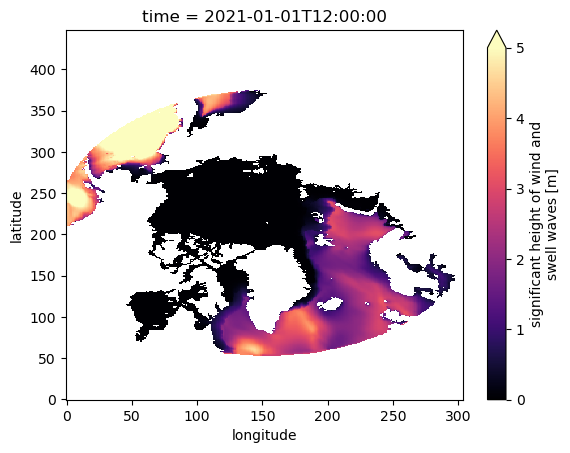

In [225]:
## Select the time index
ds_ww3['hs'].isel(time=4).plot(cmap="magma",vmin=0,vmax=5)

All the same as for ds_nxm, just changes in the variables

## Where is ice affected by waves?

In [226]:
hs_threshold = 0.3 
ds_ww3["wmiz"] = ds_ww3["hs"].where( (ds_ww3['hs']>hs_threshold)  & (ds_ww3['ice']>0.15) )


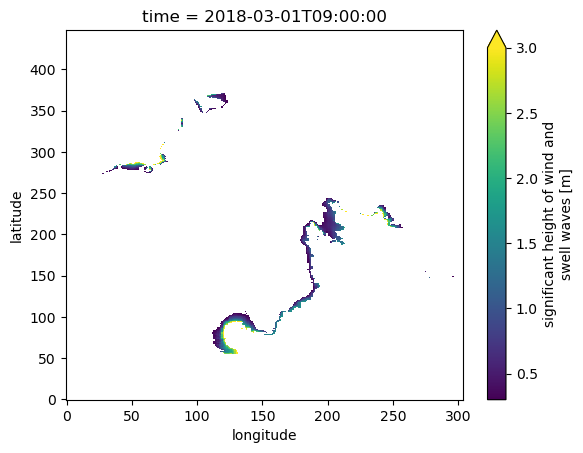

In [67]:
ds_ww3["wmiz"].isel(time=3).plot(vmin=hs_threshold,vmax=3)

## Aligning & comparing datasets

# To go further

Comparison with observations?

- In-situ: 





- Satellites:






- Impact of waves on sea ice:



